In [101]:
import pennylane as qml
import tensorflow as tf
import sklearn.datasets
from sklearn.datasets import fetch_openml

import numpy as np

from matplotlib import pyplot as plt

tf.keras.backend.set_floatx('float64')

In [102]:
import sys
print(sys.version)

3.9.13 (tags/v3.9.13:6de2ca5, May 17 2022, 16:36:42) [MSC v.1929 64 bit (AMD64)]


## Load and reduce the data

Load the MNIST data and check number of training and test examples

In [103]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0  # add colour dimension

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


Create a function to filter out only 3 and 6

In [104]:
def filter_36(x, y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y

In [105]:
x_train, y_train = filter_36(x_train, y_train)
x_test, y_test = filter_36(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12049
Number of filtered test examples: 1968


Plot the original images

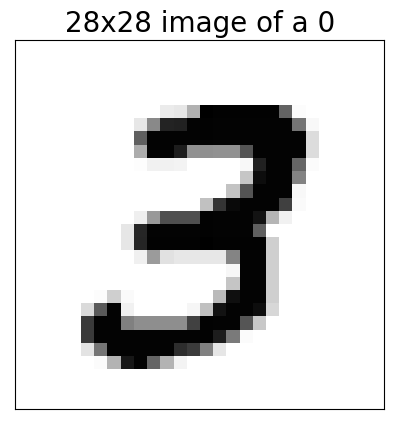

In [106]:
plt.imshow(x_train[0, :, :, 0], cmap='Greys')
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
plt.title("28x28 image of a 0", fontsize=20)
# save to file as pdf
plt.savefig('28x28_MNIST_0.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

Reduce images to 3x3

In [107]:
# x_train_small = tf.image.resize(x_train, (3,3)).numpy()
# x_test_small = tf.image.resize(x_test, (3,3)).numpy()

In [108]:
# plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1, cmap='Greys')
# ax = plt.gca()
# ax.set_xticks([])
# ax.set_yticks([])
# plt.title("9x9 image of a 0", fontsize=20)
# # save to file as pdf
# plt.savefig('9x9_MNIST_0.pdf', bbox_inches='tight', pad_inches=0)
# plt.show()

Flatten 28x28 to 784x1

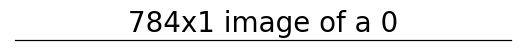

In [109]:
# x_train_small = x_train_small[:,4,:,:].reshape((-1,9))  # take only central slices
# x_test_small = x_test_small[:,4,:,:].reshape((-1,9))  # take only central slices

x_train_small = x_train.reshape((-1,784))  
x_test_small = x_test.reshape((-1,784))  

plt.imshow(x_train_small[0,:].reshape((1,-1)), vmin=0, vmax=1, cmap='Greys')
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
plt.title("784x1 image of a 0", fontsize=20)
# save to file as pdf
plt.savefig('784x1_MNIST_0.pdf', bbox_inches='tight', pad_inches=0)
plt.show()


In [110]:
print(len(x_train_small[0]))
print(x_train_small.shape)
x_test_small.shape


784
(12049, 784)


(1968, 784)

In [111]:
len(x_train_small[0,:])


784

In [112]:
# x_train_small_amplitude_encoded = qml.AmplitudeEmbedding(x_train_small, wires=range(10), pad_with=0.0, normalize=True)  # for pennylane 0.11.0
# print(x_train_small_amplitude_encoded.parameters)
# print(len(x_train_small_amplitude_encoded.parameters[0]))
# len(x_train_small_amplitude_encoded.parameters[0][0])

In [113]:
# x_test_small_amplitude_encoded = qml.AmplitudeEmbedding(x_test_small, wires=range(10), pad_with=0.0, normalize=True)  # for pennylane 0.11.0
# print(x_test_small_amplitude_encoded.parameters)
# print(len(x_test_small_amplitude_encoded.parameters[0]))
# len(x_test_small_amplitude_encoded.parameters[0][0])

In [114]:
np.min(x_train_small[0,:])

0.0

In [115]:
np.sum((x_train_small[0,:]/np.sqrt(np.sum(x_train_small[0,:]**2)))**2)

1.0

In [116]:
print(x_train_small[0,:].shape)
print(x_train_small[0,:].reshape(1, -1).shape)
# pd.Series(x_train_small[0,:]).value_counts()

(784,)
(1, 784)


In [117]:
frqi_encoded_x_train[0,:].reshape(1, -1).shape

(1, 1568)

In [118]:
x_train_small

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [119]:
import math
import numpy as np

def frqi_amplitudes(inputs):
    frqi_encoded_inputs = []
    for i in range(inputs.shape[0]):
        frqi_encoded_input = []
        for j in range(inputs.shape[1]):
            frqi_encoded_input.append((1/np.sqrt(inputs.shape[1]))*(math.cos((math.pi*inputs[i][j])/2)))
            frqi_encoded_input.append((1/np.sqrt(inputs.shape[1]))*(math.sin((math.pi*inputs[i][j])/2)))
        frqi_encoded_inputs.append(frqi_encoded_input)
        
    return np.array(frqi_encoded_inputs)

frqi_encoded_x_train = frqi_amplitudes(x_train_small)
print(frqi_encoded_x_train.shape)
frqi_encoded_x_test = frqi_amplitudes(x_test_small)
print(frqi_encoded_x_test.shape)

(12049, 1568)
(1968, 1568)


In [120]:
print((frqi_encoded_x_train[0,:].shape))
print(len(frqi_encoded_x_train[0,:][::2]))
print(len(frqi_encoded_x_train[0,:][1::2]))

(1568,)
784
784


In [121]:
np.sum(frqi_encoded_x_train[1,:]**2)

0.9999999999999998

## Set up the Quantum Neural Network

Create quantum circuit using pennylane qnode, then conver this to a Keras layer to make a Keras model

In [122]:

def frqi_embedding(encoded_inputs, n_qubits):
    n_values = len(encoded_inputs)
    n_padding = 2**n_qubits - n_values
    state_vector = np.pad(encoded_inputs, (0, n_padding), constant_values=(0, 0))
    qml.QubitStateVector(state_vector, wires=range(n_qubits))


n_qubits = 11
n_layers = 1
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, diff_method="adjoint")
def qnode(inputs, weights):

    frqi_embedding(inputs, n_qubits)
        
    for jj in range(n_layers):
        for ii in range(n_qubits-1):
            qml.RZ(weights[jj,2*ii,0], wires=0)
            qml.RY(weights[jj,2*ii,1], wires=0)
            qml.RZ(weights[jj,2*ii,2], wires=0)

            qml.RZ(weights[jj,2*ii+1,0], wires=ii+1)
            qml.RY(weights[jj,2*ii+1,1], wires=ii+1)
            qml.RZ(weights[jj,2*ii+1,2], wires=ii+1)

            #qml.U3(*list(weights[jj,2*ii,:]), wires=0)
            #qml.U3(*list(weights[jj,2*ii+1,:]), wires=ii+1)
            qml.CNOT(wires=[ii+1,0])
            
        qml.RZ(weights[jj,2*(n_qubits-1),0], wires=0)
        qml.RY(weights[jj,2*(n_qubits-1),1], wires=0)
        qml.RZ(weights[jj,2*(n_qubits-1),2], wires=0)

    return qml.expval(qml.PauliZ(0))

weight_shapes = {"weights": (n_layers, 2*(n_qubits-1)+1, 3) }


qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=1, name="quantumLayer")
inputs = tf.keras.Input(shape=(1568,), name="inputs")

outputs = qlayer(inputs)
model = tf.keras.Model(inputs=inputs, outputs=outputs, name="QNN")

testImage = x_train_small[1,:]  /np.sqrt(np.sum(x_train_small[1,:]**2))
# print(testImage)
# normalization_factor = np.sqrt(np.sum(np.abs(frqi_encoded_x_train[0,:])**2))
# normalized_frqi_encoded_image = frqi_encoded_x_train[0,:] / normalization_factor
model.predict(frqi_encoded_x_train[0,:].reshape(1, -1)) #.reshape(1, -1))
print(model.summary())

1/1 [==============================] - 0s 390ms/step
Model: "QNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1568)]            0         
                                                                 
 quantumLayer (KerasLayer)   (None, 1)                 63        
                                                                 
Total params: 63
Trainable params: 63
Non-trainable params: 0
_________________________________________________________________
None


Redefine the classification values to match the Hinge loss

In [123]:
y_train_hinge = 2.0*y_train-1.0
y_test_hinge = 2.0*y_test-1.0

Define the hinge accuracy

In [124]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

## Compile and train the model

Compile the model using the hinge loss and accuracy and the Adam optimiser

In [125]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [126]:
print(model.summary())

Model: "QNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1568)]            0         
                                                                 
 quantumLayer (KerasLayer)   (None, 1)                 63        
                                                                 
Total params: 63
Trainable params: 63
Non-trainable params: 0
_________________________________________________________________
None


Train the model over 20 epochs

In [127]:
EPOCHS = 60
BATCH_SIZE = 32

NUM_EXAMPLES = 512 #x_train_small.shape[0]
print(NUM_EXAMPLES)

x_train_sub = frqi_encoded_x_train[:NUM_EXAMPLES,:]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

x_test_sub = frqi_encoded_x_test[:,:]
y_test_sub = y_test_hinge[:]

qnn_history_1layer = model.fit(
      x_train_sub, y_train_hinge_sub,
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_sub, y_test_sub))

qnn_results_1layer = model.evaluate(x_test_sub, y_test_sub)

512
Epoch 1/60
16/16 [==============================] - 165s 11s/step - loss: 0.9956 - hinge_accuracy: 0.6621 - val_loss: 0.9960 - val_hinge_accuracy: 0.6411
Epoch 2/60
16/16 [==============================] - 160s 10s/step - loss: 0.9941 - hinge_accuracy: 0.6934 - val_loss: 0.9944 - val_hinge_accuracy: 0.6749
Epoch 3/60
16/16 [==============================] - 163s 11s/step - loss: 0.9928 - hinge_accuracy: 0.7266 - val_loss: 0.9931 - val_hinge_accuracy: 0.7011
Epoch 4/60
16/16 [==============================] - 164s 11s/step - loss: 0.9915 - hinge_accuracy: 0.7559 - val_loss: 0.9918 - val_hinge_accuracy: 0.7167
Epoch 5/60
16/16 [==============================] - 159s 10s/step - loss: 0.9903 - hinge_accuracy: 0.7598 - val_loss: 0.9904 - val_hinge_accuracy: 0.7288
Epoch 6/60
16/16 [==============================] - 161s 10s/step - loss: 0.9889 - hinge_accuracy: 0.7793 - val_loss: 0.9890 - val_hinge_accuracy: 0.7384
Epoch 7/60
16/16 [==============================] - 166s 11s/step - loss

In [37]:
qnn_history_1layer.history

{'loss': [1.0311012004276647,
  1.0250235319926155,
  1.0196964403169266,
  1.01471133509908,
  1.0100750765270405,
  1.0057250716143638,
  1.0009896193803847,
  0.9957717999531648,
  0.9896753822553016,
  0.9819768965700593,
  0.9721370079199381,
  0.9601083144325306,
  0.9455391640256816,
  0.928394949393776,
  0.9081673062703529,
  0.8866051146235268,
  0.8629914383864971,
  0.8387328861895731,
  0.8150649491568883,
  0.7914782382059122],
 'hinge_accuracy': [0.5234375,
  0.52734375,
  0.529296875,
  0.52734375,
  0.525390625,
  0.525390625,
  0.525390625,
  0.5234375,
  0.525390625,
  0.52734375,
  0.5390625,
  0.548828125,
  0.556640625,
  0.55859375,
  0.576171875,
  0.615234375,
  0.708984375,
  0.724609375,
  0.73828125,
  0.7421875],
 'val_loss': [0.9706141030427916,
  0.9666631520010215,
  0.9631757426577569,
  0.9599528235616132,
  0.9570048701414415,
  0.9541040429850104,
  0.9508285935730798,
  0.9465670882763517,
  0.9410590800215068,
  0.9339222861640597,
  0.925107741535

Create and train a 2 layer version of the QNN

In [38]:
n_qubits = 9
n_layers = 2
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, diff_method="adjoint")
def qnode(inputs, weights):

    for ii in range(n_qubits):
        qml.RY(np.pi * inputs[ii], wires=ii)

    for jj in range(n_layers):
        for ii in range(n_qubits-1):
            qml.RZ(weights[jj,2*ii,0], wires=0)
            qml.RY(weights[jj,2*ii,1], wires=0)
            qml.RZ(weights[jj,2*ii,2], wires=0)

            qml.RZ(weights[jj,2*ii+1,0], wires=ii+1)
            qml.RY(weights[jj,2*ii+1,1], wires=ii+1)
            qml.RZ(weights[jj,2*ii+1,2], wires=ii+1)

            #qml.U3(*list(weights[jj,2*ii,:]), wires=0)
            #qml.U3(*list(weights[jj,2*ii+1,:]), wires=ii+1)
            qml.CNOT(wires=[ii+1,0])
            
        qml.RZ(weights[jj,2*(n_qubits-1),0], wires=0)
        qml.RY(weights[jj,2*(n_qubits-1),1], wires=0)
        qml.RZ(weights[jj,2*(n_qubits-1),2], wires=0)

    return qml.expval(qml.PauliZ(0))

weight_shapes = {"weights": (n_layers, 2*(n_qubits-1)+1, 3) }


qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=1, name="quantumLayer")
inputs = tf.keras.Input(shape=(n_qubits,), name="inputs")
outputs = qlayer(inputs)
model2 = tf.keras.Model(inputs=inputs, outputs=outputs, name="QNN")

model2.predict(x_train_small[0,:])
print(model2.summary())

1/1 [==============================] - 0s 174ms/step
Model: "QNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 9)]               0         
                                                                 
 quantumLayer (KerasLayer)   (None, 1)                 102       
                                                                 
Total params: 102
Trainable params: 102
Non-trainable params: 0
_________________________________________________________________
None


In [39]:
model2.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

In [40]:
EPOCHS = 20
BATCH_SIZE = 32

NUM_EXAMPLES = 512 #x_train_small.shape[0]
print(NUM_EXAMPLES)

x_train_sub = x_train_small[:NUM_EXAMPLES,:]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

x_test_sub = x_test_small[:,:]
y_test_sub = y_test[:]

qnn_history_2layer = model2.fit(
      x_train_sub, y_train_hinge_sub,
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      verbose=1,
      validation_data=(x_test_sub, y_test_sub))

qnn_results_2layer = model2.evaluate(x_test_sub, y_test_sub)

512
Epoch 1/20
16/16 [==============================] - 222s 14s/step - loss: 1.0098 - hinge_accuracy: 0.4863 - val_loss: 1.0036 - val_hinge_accuracy: 0.5076
Epoch 2/20
16/16 [==============================] - 220s 14s/step - loss: 0.9684 - hinge_accuracy: 0.4863 - val_loss: 0.9674 - val_hinge_accuracy: 0.5136
Epoch 3/20
16/16 [==============================] - 229s 15s/step - loss: 0.9300 - hinge_accuracy: 0.5859 - val_loss: 0.9340 - val_hinge_accuracy: 0.6038
Epoch 4/20
16/16 [==============================] - 254s 17s/step - loss: 0.8929 - hinge_accuracy: 0.6426 - val_loss: 0.9018 - val_hinge_accuracy: 0.6280
Epoch 5/20
16/16 [==============================] - 215s 14s/step - loss: 0.8574 - hinge_accuracy: 0.6621 - val_loss: 0.8704 - val_hinge_accuracy: 0.6436
Epoch 6/20
16/16 [==============================] - 217s 14s/step - loss: 0.8209 - hinge_accuracy: 0.6914 - val_loss: 0.8390 - val_hinge_accuracy: 0.6568
Epoch 7/20
16/16 [==============================] - 238s 15s/step - loss

In [41]:
qnn_history_2layer.history

{'loss': [1.009821054860213,
  0.9684191698876125,
  0.9300229240522239,
  0.8929492670532166,
  0.8573626919258974,
  0.8208722536562981,
  0.7866627982243429,
  0.7515325264834175,
  0.7203507453819022,
  0.6898061863656223,
  0.6637916434775687,
  0.6400038263355325,
  0.619614620434799,
  0.6024408002530459,
  0.5878237122752805,
  0.5750934807859387,
  0.5645437526506826,
  0.5552432795672883,
  0.5465176279843662,
  0.5385353059967442],
 'hinge_accuracy': [0.486328125,
  0.486328125,
  0.5859375,
  0.642578125,
  0.662109375,
  0.69140625,
  0.705078125,
  0.73046875,
  0.74609375,
  0.75390625,
  0.767578125,
  0.76953125,
  0.783203125,
  0.79296875,
  0.791015625,
  0.783203125,
  0.78515625,
  0.787109375,
  0.791015625,
  0.787109375],
 'val_loss': [1.0036027948770632,
  0.9674171336706109,
  0.9339567651260925,
  0.9018363782326826,
  0.8703909542974996,
  0.8390495402559895,
  0.8073122413022212,
  0.7766137141827528,
  0.7459465157536118,
  0.7182409780841016,
  0.6914591

## Plot the results!

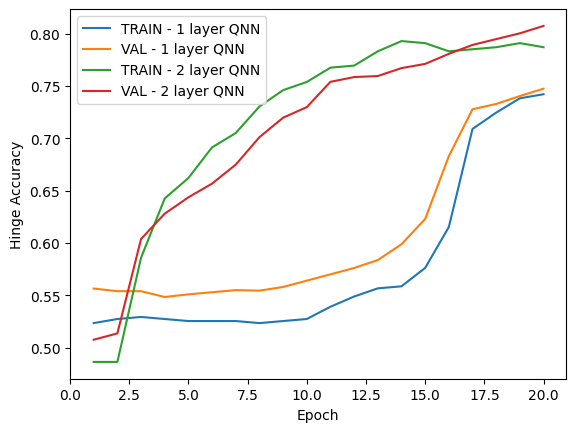

In [42]:
# plot the hinge accuracy for the qnn history for both 1 and 2 layer on the same axes
plt.plot(np.arange(1,21), qnn_history_1layer.history["hinge_accuracy"], label="TRAIN - 1 layer QNN")
plt.plot(np.arange(1,21), qnn_history_1layer.history["val_hinge_accuracy"], label="VAL - 1 layer QNN")
plt.plot(np.arange(1,21), qnn_history_2layer.history["hinge_accuracy"], label="TRAIN - 2 layer QNN")
plt.plot(np.arange(1,21), qnn_history_2layer.history["val_hinge_accuracy"], label="VAL - 2 layer QNN")
plt.xlabel("Epoch")
plt.ylabel("Hinge Accuracy")
plt.legend()
# modify x_ticks to also include 20
plt.xticks(np.arange(0, 21, 2.5))
# save as pdf with tight layout and no padding
plt.savefig("qnn_hinge_accuracy.pdf", bbox_inches="tight", pad_inches=0)
plt.show()

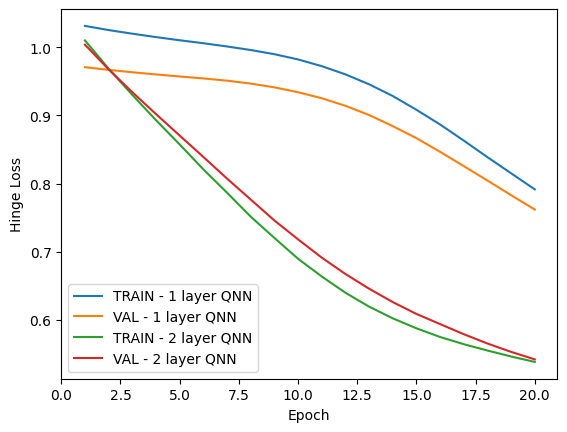

In [43]:
# plot the hinge accuracy for the loss for both 1 and 2 layer on the same axes
plt.plot(np.arange(1,21), qnn_history_1layer.history["loss"], label="TRAIN - 1 layer QNN")
plt.plot(np.arange(1,21), qnn_history_1layer.history["val_loss"], label="VAL - 1 layer QNN")
plt.plot(np.arange(1,21), qnn_history_2layer.history["loss"], label="TRAIN - 2 layer QNN")
plt.plot(np.arange(1,21), qnn_history_2layer.history["val_loss"], label="VAL - 2 layer QNN")
plt.xlabel("Epoch")
plt.ylabel("Hinge Loss")
plt.legend()
# modify x_ticks to also include 20
plt.xticks(np.arange(0, 21, 2.5))
# save as pdf with tight layout and no padding
plt.savefig("qnn_hinge_loss.pdf", bbox_inches="tight", pad_inches=0)
plt.show()